In [9]:
# VAMO 
import combo
import pandas as pd
import numpy as np
import scipy.stats
import six

from keras.models import load_model
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from keras import callbacks
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Lambda, merge, Dropout
from keras.models import Model
from keras import backend as K
from keras.utils.visualize_util import plot
from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Simulator(object):
    def __init__(self, X, y, decoder):
        self.decoder = decoder
        self.X = X
        self.y = y
    
    def __call__(self, z):
        z = z.reshape((1, -1))
        x = self.decoder.predict(z)
        rank_x = scipy.stats.rankdata(x)
        a = np.zeros_like(rank_x)
        a[rank_x > 8] = 1
               
        for n in six.moves.range(self.X.shape[0]):
            if np.allclose(a, self.X[n, :]):
                t = self.y[n]
                break
        
        return t

In [11]:
def sampling(args):
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(2,), mean=0., std=1.0)
    return z_mean + z_sigma * epsilon

In [3]:
# Data Load

In [12]:
df = pd.read_csv("data/impurity_SiGe.csv")
y = df["TC"].as_matrix().astype("float32")
X = df.iloc[:, 0:-1].as_matrix().astype("float32")

In [13]:
x = Input(shape=(X.shape[1],)) # 入力層
hidden = Dense(200, activation='relu')(x)  # 隠れ層
d_hidden = Dropout(0.5)(hidden)
z_mean = Dense(2, activation='linear')(d_hidden) # p(z|x)の平均
z_sigma = Dense(2, activation='linear')(d_hidden) # p(z|x)の標準偏差
z = Lambda(sampling, output_shape=(2,))([z_mean, z_sigma]) # z 〜 p(z|x)
decoder_h = Dense(200, activation='relu')
decoder_mean = Dense(X.shape[1], activation='sigmoid')
h_decoded = decoder_h(z)
d_h_decoded = Dropout(0.5)(h_decoded)
x_decoded_mean = decoder_mean(d_h_decoded)

vae = Model(x, x_decoded_mean)
encoder = Model(x,z)
z_in = Input(shape=(2, ))
_h_decoded = decoder_h(z_in)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder= Model(input=z_in, output=_x_decoded_mean)

In [14]:
vae.load_weights("model/vae.hdf5")
# encoder.load_weights("model/encoder.hdf5")

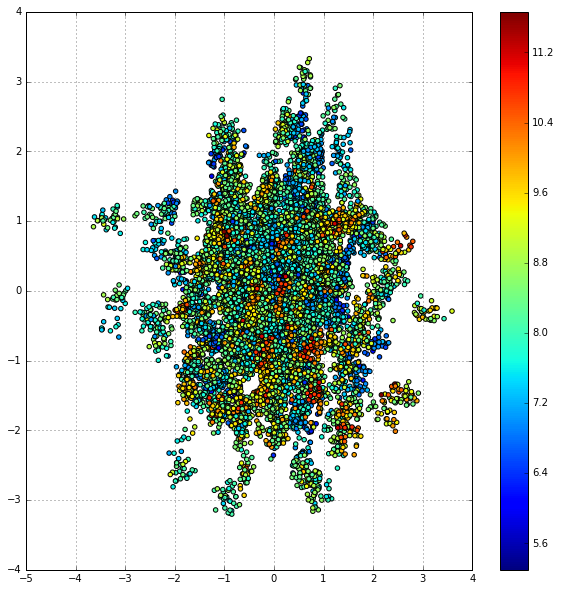

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(encoder.predict(X)[:, 0], encoder.predict(X)[:, 1], c=y)
plt.colorbar()
plt.grid()

In [16]:
sim = Simulator(X, y, decoder)

In [17]:
# random sampling
n = 20
nbasis = 5000
config = combo.misc.set_config()
index = np.random.permutation(six.moves.range(X.shape[0]))

train_X = X[index[0:n], :]
train_Y = y[index[0:n]]

In [18]:
predictor = combo.blm.predictor(config)
train = combo.variable(encoder.predict(train_X), train_Y)
predictor.fit(train, nbasis)

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 33.6397593841
50-th epoch, marginal likelihood 33.1822108548
100-th epoch, marginal likelihood 32.9948715092
150-th epoch, marginal likelihood 32.9003027568
200-th epoch, marginal likelihood 32.8295487998
250-th epoch, marginal likelihood 32.7690325806
300-th epoch, marginal likelihood 32.7178019342
350-th epoch, marginal likelihood 32.6759581362
400-th epoch, marginal likelihood 32.6430880531
450-th epoch, marginal likelihood 32.6182695953
500-th epoch, marginal likelihood 32.6002473649
Done

 Parameters of Gaussian kernel 
 
 width  =  [ 3.]
 scale  =  1.0
 scale2 =  1.0
 



In [34]:
class Score(object):
    def __call__(self, x, predictor, train):
        z = x.copy()
        z = z.reshape((1, -1))
        return -combo.search.score.EI(predictor, train, combo.variable(X=z))

In [51]:
class InitParams(object):
    def __init__(self, encoder, X):
        self.encoder = encoder
        self.X = X
        
    def __call__(self, N=1):
        index = np.random.permutation(six.moves.range(self.X.shape[0]))
        x = self.encoder.predict(self.X[index[0:N], :])
        self.X = self.X[index[N:], :]
        return x

In [50]:
class Optimize(object):
    def __init__(self, init_params, score):
        self.init_params = init_params
        self.score = score
    
    def __call__(self, predictor, train, N=1):
        min_fun = np.inf
        x = self.init_params(N)
        for n in six.moves.range(N):
             res = scipy.optimize.minimize(self.score, x[n, :], args=(predictor, train))

SyntaxError: unexpected EOF while parsing (<ipython-input-50-b8fab18de6ac>, line 2)

In [49]:
init_params = InitParams(encoder, X)
init_params()

array([[-0.43427354,  0.10012153]], dtype=float32)

In [37]:
class optimize(object):
    def __init__(self, init_params, score):
        self.init_params = init_params
        self.score = score
                
    def __call__(self, predictor, train):
        min_fun = np.inf
        x = self.init_params(self.N)

        for n in range(N):
            res = scipy.optimize.minimize(score, x[n, :], args=(predictor, train))
            if res.fun < min_fun:
                opt_x = res.x
        return opt_x